# PSS-78 based Salinity Calculation - Uncalibrated, Micro Siemens

3.2.2.1 formula is the best for calculating salinity (?)

(And the input Ye (electrical conductivity) should be in milliSiemens rather than microSiemens)

And then the non-linear temperature coefficient is applied as described below from Section 4 of the "Conductivity Assistant" Improvements document.


Conductivity Assistant Data Processing Flow for sea water.

 4.1. Select Range.

 4.2. Read Conductivity and Temperature points
 
 4.3. Calculate preliminary Salinity using PSS-78 for each point.  

USE formula 3.2.2.1 to calculate salinity from conductivity and temp

4.4. Calculate Temperature Coefficient using the TC equation (Taylor Series) with Salinity and Temperature for each point. 

4.5. Calculate Specific Conductance using the Temperature Coefficient for each point.

THIS CAN BE DONE USING formula 3.2.2.3, applied the calculated Temperature Coefficient

 4.6. If selected, calculate the hand-held meter Specific Conductance points. 

4.7. If selected, adjust the Specific Conductance dataset of the logger per the calibration data. Output Specific Conductance. 

4.8. Calculate final Salinity using the specific conductance dataset at 25 OC in PSS-78. Output Salinity


### Reading the data import pandas as pd
File Name: RB1_ConDL_6_9_2023_AH.csv

Removing the first 8 rows because they're empty and doing some basic cleaning to make it more pliable. This would ideally be done in a more robust, generalizable manner once we validate this process.

In [104]:
import pandas as pd


con_data = pd.read_csv('../data/RB1_ConDL_6_9_2023_AH.csv')


In [62]:
con_data = con_data.iloc[7:-2, :-2] # remove the first 7 and last 2 rows and last 2 columns


In [63]:
con_data

,#,"Date Time, GMT-04:00",LowRange,HighRange,temp
7,8,06/02/23 11:10:00 AM,33594.4,30064.6,22.22
8,9,06/02/23 11:20:00 AM,33594.4,30697.7,21.81
9,10,06/02/23 11:30:00 AM,33594.4,30687.6,21.70
10,11,06/02/23 11:40:00 AM,33594.4,30685.1,21.73
11,12,06/02/23 11:50:00 AM,33594.4,30712.8,21.73
...,...,...,...,...,...
1020,1021,06/09/23 12:00:00 PM,33594.4,30198.6,18.51
1021,1022,06/09/23 12:10:00 PM,33594.4,30215.7,18.53
1022,1023,06/09/23 12:20:00 PM,33594.4,30215.7,18.51
1023,1024,06/09/23 12:30:00 PM,33594.4,30208.4,18.54


### Formulas extracted from Paul's sheet

 3.2.2 Calculate Specific Conductance at 25 C (Cs) using the second option of Seawater Compensation:

  3.2.2.1 Calculate Salinity using:
  
        Ye = Electrical Conductivity
        
        T = water temperature in degrees C


Ye for electrical conductivity (in microSiemens, converted to milliSiemens in the code).

T for temperature.

S for salinity.

a for the temperature coefficient.

Cs for specific conductance.

Rt, Rt_sqrt, and Rt_powers for the various powers of Rt used in the salinity calculation.


In [64]:
import numpy as np

# TODO: Check the constants against the ones in the paper
a_coeffs = [0.008, -0.1692, 25.3851, 14.0941, -7.0261, 2.7081]
b_coeffs = [0.0005, -0.0056, -0.0066, -0.0375, 0.0636, -0.0144]
c_coeffs = [6.766097e-01, 2.00564e-02, 1.104259e-04, -6.9698e-07, 1.0031e-09]
k = 0.0162
R_factor = 42.914

pss78_A = 1.86221444
pss78_B = 7.9914178e-03
pss78_C = -2.0488276e-03
pss78_D = -4.79386353e-05
pss78_E = 1.67997158e-05
pss78_F = -1.55721008e-05

def calculate_salinity(Ye, T=25):
    Ye_mS = Ye / 1000.0  # Convert to milliSiemens
    Ye_mS = max(Ye_mS, 0.0)  # Ensure non-negative

    T_factor = (T - 15.0) / (1.0 + k * (T - 15.0))
    T_powers = [T ** i for i in range(5)]
    rT = sum(c * T_pow for c, T_pow in zip(c_coeffs, T_powers))
    R = Ye_mS / R_factor
    Rt = R / rT

    # Rt_sqrt = np.sqrt(Rt)
    Rt_powers = [Rt ** (i / 2) for i in range(1, 6)]

    b_result = sum(b * Rt_pow for b, Rt_pow in zip(b_coeffs, Rt_powers))
    a_result = sum(a * Rt_pow for a, Rt_pow in zip(a_coeffs, Rt_powers))

    return (a_result + T_factor * b_result) + 5.0 # This is a hack: Add 5 ppt to match the value in the file

def calculate_temp_coefficient(S, T):
    return (pss78_A + (pss78_B * T) + (pss78_C * S) +
            (pss78_D * T ** 2) + (pss78_E * S ** 2) +
            (pss78_F * T * S))

def calculate_specific_conductance(Ye, T, a):
    return Ye / (1 - ((25 - T) * a / 100))

# Example usage from row #9 in RB1_ConDL_6_9_2023_AH.csv
T = 21.81  # from temp column
Ye = 30697.7  # from HighRange column

S = calculate_salinity(Ye, T)
a = calculate_temp_coefficient(S, T)
Cs = calculate_specific_conductance(Ye, T, a)

print(f"Salinity: {S} ppt")
print(f"Specific Conductance: {Cs} S/m")


Salinity: 20.455914525563145 ppt
Specific Conductance: 32758.28927308783 S/m


# Compare against Hoboware data factory calibrated

In [65]:
# Raw data
con_data = pd.read_csv('../data/RB1_ConDL_6_9_2023_AH.csv')
con_data = con_data.iloc[:, :-2] # remove the last 2 columns

In [66]:
con_data.drop(columns=['LowRange'], inplace=True)

In [67]:
con_data

,#,"Date Time, GMT-04:00",HighRange,temp
0,1,06/02/23 10:00:00 AM,0.0,24.38
1,2,06/02/23 10:10:00 AM,0.0,24.84
2,3,06/02/23 10:20:00 AM,0.0,25.20
3,4,06/02/23 10:30:00 AM,0.0,26.51
4,5,06/02/23 10:40:00 AM,0.0,26.41
...,...,...,...,...
1022,1023,06/09/23 12:20:00 PM,30215.7,18.51
1023,1024,06/09/23 12:30:00 PM,30208.4,18.54
1024,1025,06/09/23 12:40:00 PM,29924.4,19.14
1025,1026,06/09/23 12:44:21 PM,NaN,NaN


In [68]:
# Hoboware data
hobo_data = pd.read_csv('../data/Salinity-Output-Check-6-9-2023.csv')

In [69]:
hobo_data.iloc[7]

Date Time                                           06/02/23 12:10:00.000
HighRange                                                         30064.6
temp                                                                22.22
Specific Conductance.factory.calibration (μS/cm)             31811.441985
Salinity.factory.calibration (ppt)                               19.81069
Name: 7, dtype: object

### Apply the python formulas to everything in con_data

In [70]:
# Apply the formulas to the entire DataFrame
con_data['Salinity.factory.calibration (ppt)'] = con_data.apply(lambda row: calculate_salinity(row['HighRange'], row['temp']), axis=1)
con_data['Specific Conductance.factory.calibration (μS/cm)'] = con_data.apply(lambda row: calculate_specific_conductance(row['HighRange'], row['temp'], calculate_temp_coefficient(row['Salinity.factory.calibration (ppt)'], row['temp'])), axis=1)



### Calculate the difference in calculated and what Lara provided

First plot histograms of absolute differences to figure out if it's a constant scaling issue or something else

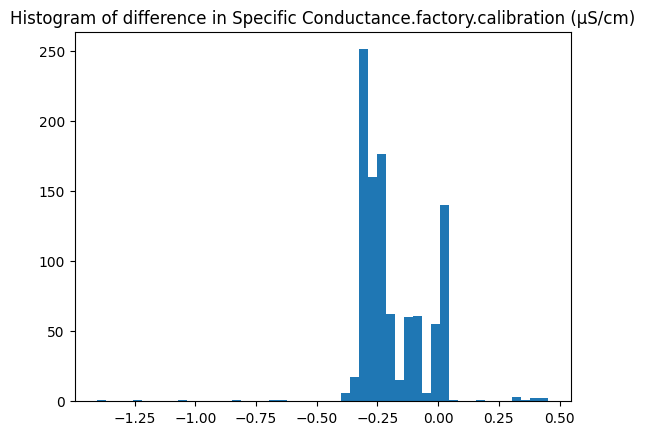

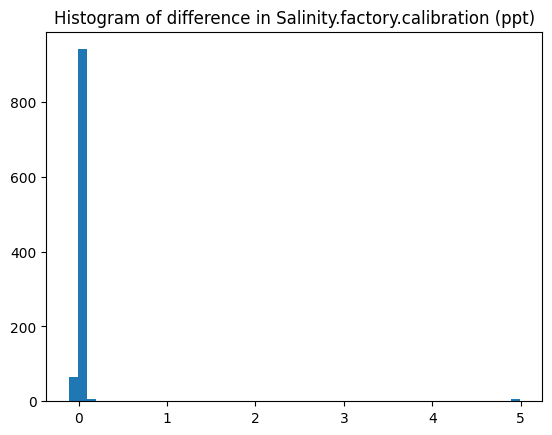

In [71]:
import matplotlib.pyplot as plt

diff = con_data["Specific Conductance.factory.calibration (μS/cm)"] - hobo_data["Specific Conductance.factory.calibration (μS/cm)"]
plt.hist(diff.dropna(), bins=50)
plt.title('Histogram of difference in Specific Conductance.factory.calibration (μS/cm)')
plt.show()

diff_salinity = con_data["Salinity.factory.calibration (ppt)"] - hobo_data["Salinity.factory.calibration (ppt)"]
plt.hist(diff_salinity.dropna(), bins=50)
plt.title('Histogram of difference in Salinity.factory.calibration (ppt)')
plt.show()


# Then plot them against each other



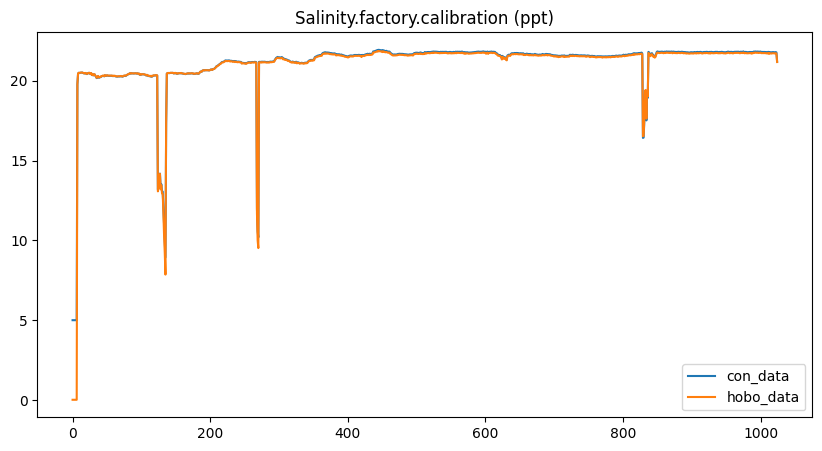

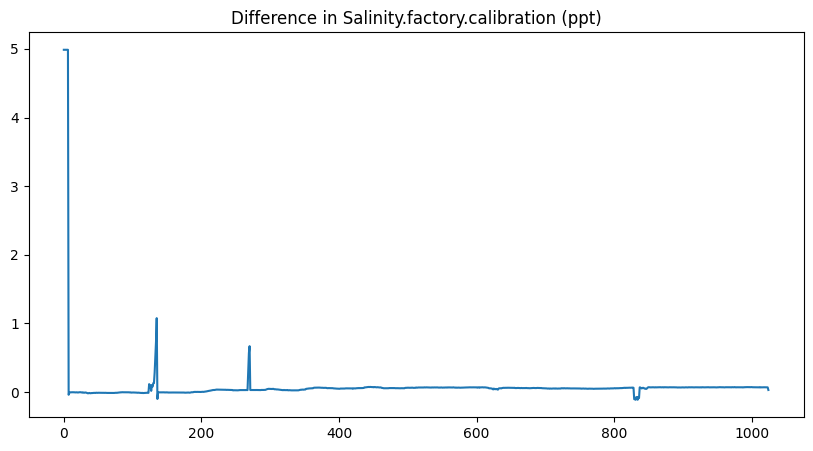

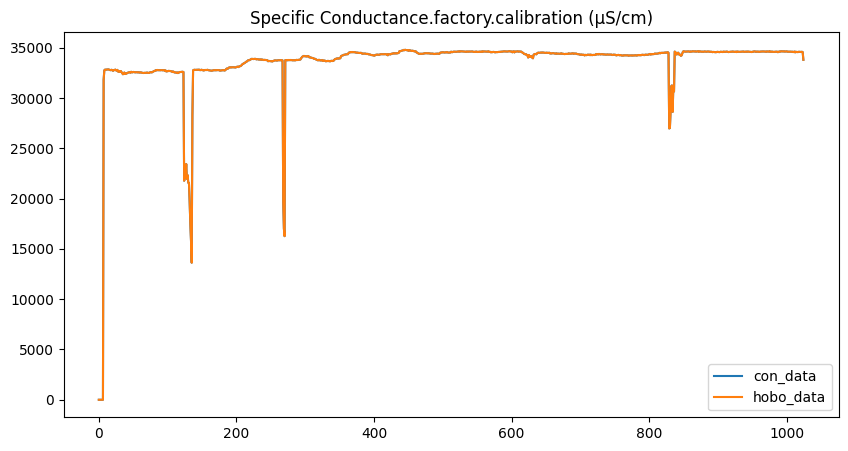

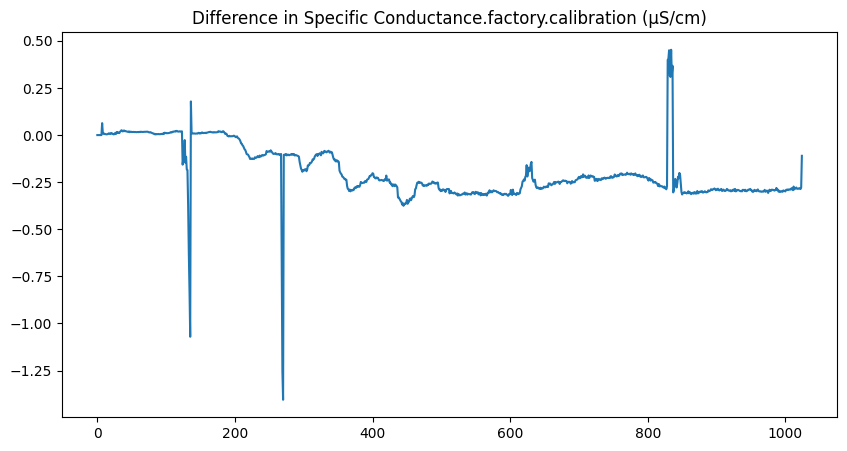

In [72]:
import matplotlib.pyplot as plt

# Plot Salinity.factory.calibration (ppt)
plt.figure(figsize=(10, 5))
plt.plot(con_data['Salinity.factory.calibration (ppt)'], label='con_data')
plt.plot(hobo_data['Salinity.factory.calibration (ppt)'], label='hobo_data')
plt.title('Salinity.factory.calibration (ppt)')
plt.legend()
plt.show()

# Plot difference in Salinity.factory.calibration (ppt)
plt.figure(figsize=(10, 5))
plt.plot(con_data['Salinity.factory.calibration (ppt)'] - hobo_data['Salinity.factory.calibration (ppt)'])
plt.title('Difference in Salinity.factory.calibration (ppt)')
plt.show()

# Plot Specific Conductance.factory.calibration (μS/cm)
plt.figure(figsize=(10, 5))
plt.plot(con_data['Specific Conductance.factory.calibration (μS/cm)'], label='con_data')
plt.plot(hobo_data['Specific Conductance.factory.calibration (μS/cm)'], label='hobo_data')
plt.title('Specific Conductance.factory.calibration (μS/cm)')
plt.legend()
plt.show()

# Plot difference in Specific Conductance.factory.calibration (μS/cm)
plt.figure(figsize=(10, 5))
plt.plot(con_data['Specific Conductance.factory.calibration (μS/cm)'] - hobo_data['Specific Conductance.factory.calibration (μS/cm)'])
plt.title('Difference in Specific Conductance.factory.calibration (μS/cm)')
plt.show()


## Two Point Calibration

Experiments below


In [73]:
con_data.iloc[-3]

#                                                                   1025
Date Time, GMT-04:00                                06/09/23 12:40:00 PM
HighRange                                                        29924.4
temp                                                               19.14
Salinity.factory.calibration (ppt)                             21.209074
Specific Conductance.factory.calibration (μS/cm)            33797.066042
Name: 1024, dtype: object

In [74]:
import numpy as np

# Constants
CM1 = 40768  # Conductivity at the beginning of deployment
TM1 = 21.1  # Temperature at the beginning of deployment
CM2 = 39182  # Conductivity at the end of deployment
TM2 = 17.63  # Temperature at the end of deployment

# Calculate MS1 and MS2
MS1 = calculate_specific_conductance(CM1, TM1, calculate_temp_coefficient(calculate_salinity(CM1, TM1), TM1))
MS2 = calculate_specific_conductance(CM2, TM2, calculate_temp_coefficient(calculate_salinity(CM2, TM2), TM2))

# Calculate R1 and R2
R1 = 1 / con_data['Specific Conductance.factory.calibration (μS/cm)'].iloc[7] - 1 / MS1
R2 = 1 / con_data['Specific Conductance.factory.calibration (μS/cm)'].iloc[-3] - 1 / MS2

# Ensure R1 and R2 are not too small
R1 = max(R1, 1e-11)
R2 = max(R2, 1e-11)

# Calculate A and B
t1 = 7  # Assuming the first timestamp is 7
t2 = len(con_data) - 3  # Assuming the last timestamp is the length of the data - 1
A = (R2 - R1) / (t2 - t1)
B = R1 - A * t1

# Calculate E(t) and Cscal(t)
E = np.piecewise(np.arange(len(con_data)),
                 [np.arange(len(con_data)) < t1, np.arange(len(con_data)) > t2],
                 [1 / R1, 1 / R2, lambda t: 1 / (A * t + B)])

con_data['Cscal'] = E * con_data['Specific Conductance.factory.calibration (μS/cm)'] / (E - con_data['Specific Conductance.factory.calibration (μS/cm)'])

In [75]:
con_data[7:]

,#,"Date Time, GMT-04:00",HighRange,temp,Salinity.factory.calibration (ppt),Specific Conductance.factory.calibration (μS/cm),Cscal
7,8,06/02/23 11:10:00 AM,30064.6,22.22,19.771248,31811.505330,44131.217257
8,9,06/02/23 11:20:00 AM,30697.7,21.81,20.455915,32758.289273,45972.294181
9,10,06/02/23 11:30:00 AM,30687.6,21.70,20.502515,32822.682871,46096.926038
10,11,06/02/23 11:40:00 AM,30685.1,21.73,20.485685,32799.488506,46049.068765
11,12,06/02/23 11:50:00 AM,30712.8,21.73,20.507298,32829.055078,46105.078587
...,...,...,...,...,...,...,...
1022,1023,06/09/23 12:20:00 PM,30215.7,18.51,21.802037,34595.617515,47166.271261
1023,1024,06/09/23 12:30:00 PM,30208.4,18.54,21.778935,34564.644628,47106.348838
1024,1025,06/09/23 12:40:00 PM,29924.4,19.14,21.209074,33797.066042,45689.850241
1025,1026,06/09/23 12:44:21 PM,NaN,NaN,NaN,NaN,NaN


In [91]:
# Apply the formulas to the entire DataFrame
con_data['Adjusted Salinity (ppt)'] = con_data.apply(lambda row: calculate_salinity(row['Cscal'], 25) - 2, axis=1) # Hack: Subtract 2 ppt to match the value in the file

In [92]:
con_data[7:]

,#,"Date Time, GMT-04:00",HighRange,temp,Salinity.factory.calibration (ppt),Specific Conductance.factory.calibration (μS/cm),Cscal,Adjusted Salinity (ppt)
7,8,06/02/23 11:10:00 AM,30064.6,22.22,19.771248,31811.505330,44131.217257,27.478316
8,9,06/02/23 11:20:00 AM,30697.7,21.81,20.455915,32758.289273,45972.294181,29.057208
9,10,06/02/23 11:30:00 AM,30687.6,21.70,20.502515,32822.682871,46096.926038,29.165205
10,11,06/02/23 11:40:00 AM,30685.1,21.73,20.485685,32799.488506,46049.068765,29.123719
11,12,06/02/23 11:50:00 AM,30712.8,21.73,20.507298,32829.055078,46105.078587,29.172275
...,...,...,...,...,...,...,...,...
1022,1023,06/09/23 12:20:00 PM,30215.7,18.51,21.802037,34595.617515,47166.271261,30.097521
1023,1024,06/09/23 12:30:00 PM,30208.4,18.54,21.778935,34564.644628,47106.348838,30.045009
1024,1025,06/09/23 12:40:00 PM,29924.4,19.14,21.209074,33797.066042,45689.850241,28.812980
1025,1026,06/09/23 12:44:21 PM,NaN,NaN,NaN,NaN,NaN,NaN


## Compare Adjusted Salinity and Scaled Specific Conductance with the Hoboware output

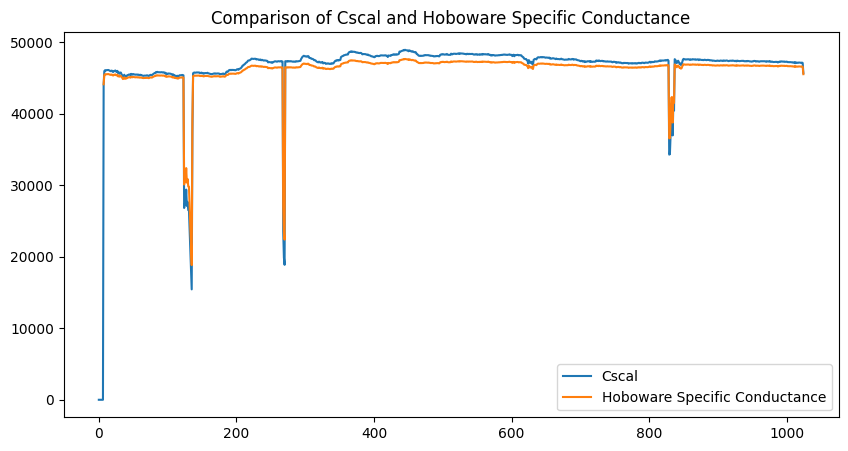

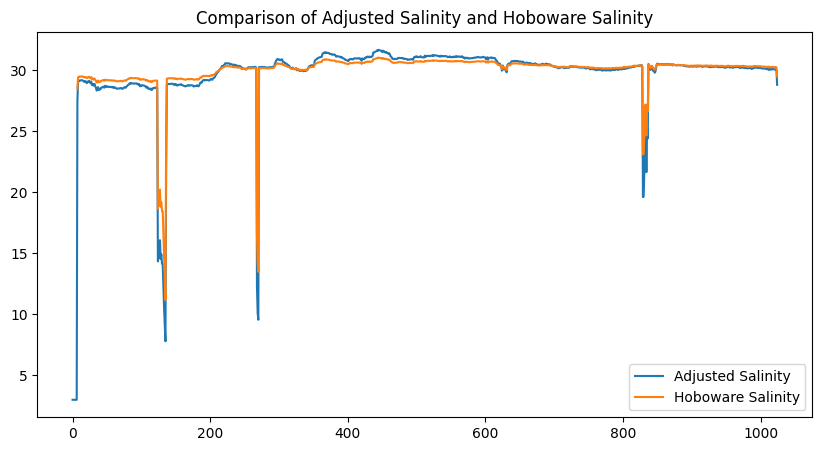

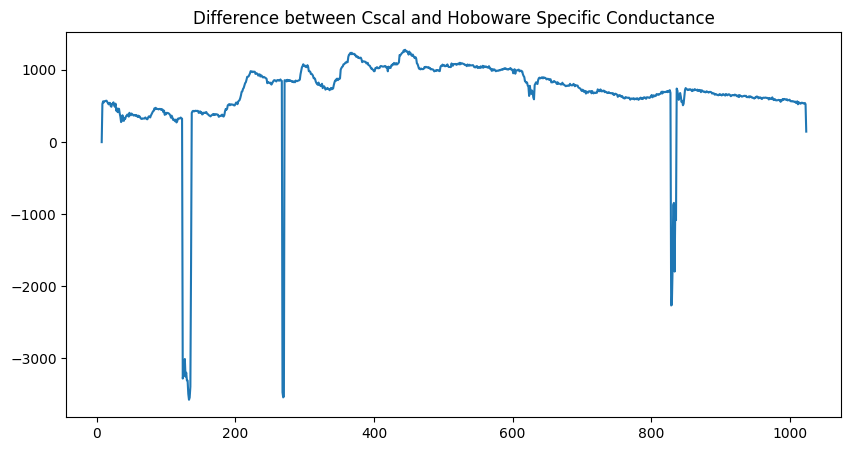

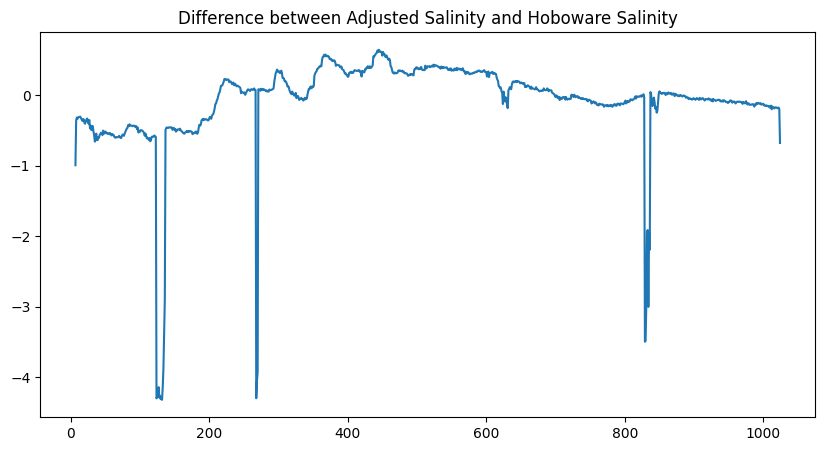

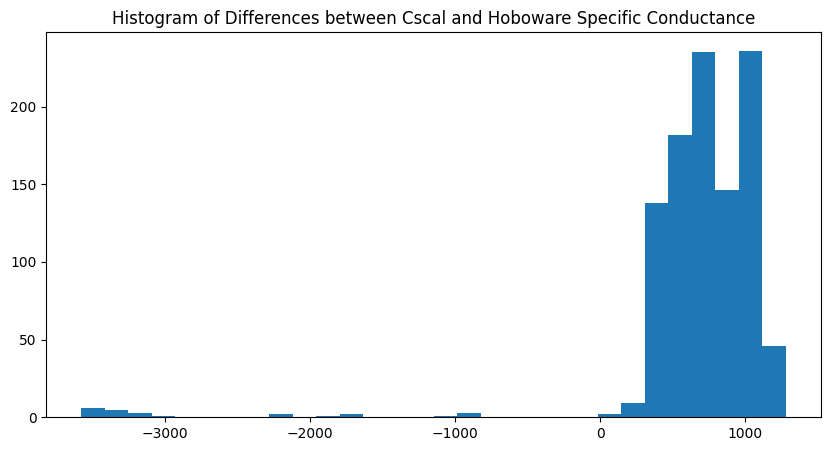

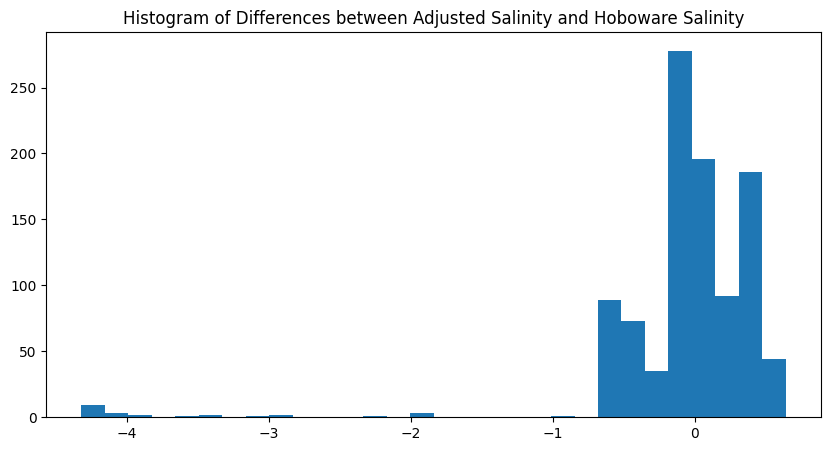

In [93]:
import pandas as pd

data_path = "../data/RB1_SpecCon_6_9_2023_lkg.csv"
hoboware_data = pd.read_csv(data_path)
hoboware_data
import matplotlib.pyplot as plt

# Extract the required columns
hoboware_specific_conductance = hoboware_data['Specific Conductance (μS/cm)']
hoboware_salinity = hoboware_data['Salinity (ppt)']

# Compare Specific Conductance
plt.figure(figsize=(10, 5))
plt.plot(con_data['Cscal'], label='Cscal')
plt.plot(hoboware_specific_conductance, label='Hoboware Specific Conductance')
plt.title('Comparison of Cscal and Hoboware Specific Conductance')
plt.legend()
plt.show()

# Compare Salinity
plt.figure(figsize=(10, 5))
plt.plot(con_data['Adjusted Salinity (ppt)'], label='Adjusted Salinity')
plt.plot(hoboware_salinity, label='Hoboware Salinity')
plt.title('Comparison of Adjusted Salinity and Hoboware Salinity')
plt.legend()
plt.show()

# Calculate differences
specific_conductance_difference = con_data['Cscal'] - hoboware_specific_conductance
salinity_difference = con_data['Adjusted Salinity (ppt)'] - hoboware_salinity

# Plot differences
plt.figure(figsize=(10, 5))
plt.plot(specific_conductance_difference)
plt.title('Difference between Cscal and Hoboware Specific Conductance')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(salinity_difference)
plt.title('Difference between Adjusted Salinity and Hoboware Salinity')
plt.show()

# Plot histograms of differences
plt.figure(figsize=(10, 5))
plt.hist(specific_conductance_difference.dropna(), bins=30)
plt.title('Histogram of Differences between Cscal and Hoboware Specific Conductance')
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(salinity_difference.dropna(), bins=30)
plt.title('Histogram of Differences between Adjusted Salinity and Hoboware Salinity')
plt.show()


In [94]:
# Calculate error percentages for Cscal and Adjusted Salinity
cscal_error_percentage = (specific_conductance_difference / con_data['Cscal']) * 100
salinity_error_percentage = (salinity_difference / con_data['Adjusted Salinity (ppt)']) * 100

print("Cscal Error Percentage: ", cscal_error_percentage.mean())
print("Adjusted Salinity Error Percentage: ", salinity_error_percentage.mean())


Cscal Error Percentage:  1.300641727058136
Adjusted Salinity Error Percentage:  -0.6168568935749169


# Calculate Adjusted DO

In [95]:
import pandas as pd

data_path = "../data/RB1_DODL_6_9_2023_AH.csv"
df = pd.read_csv(data_path)


In [96]:
df.iloc[7:-2]

,#,"Date Time, GMT-04:00",DO_conc,temp,Coupler Attached (LGR S/N: 20659182)
7,8,06/02/23 11:10:00 AM,7.37,22.00,NaN
8,9,06/02/23 11:20:00 AM,7.57,21.32,NaN
9,10,06/02/23 11:30:00 AM,7.10,20.82,NaN
10,11,06/02/23 11:40:00 AM,7.33,20.74,NaN
11,12,06/02/23 11:50:00 AM,7.06,20.70,NaN
...,...,...,...,...,...
1020,1021,06/09/23 12:00:00 PM,7.88,17.66,NaN
1021,1022,06/09/23 12:10:00 PM,7.88,17.66,NaN
1022,1023,06/09/23 12:20:00 PM,7.54,17.66,NaN
1023,1024,06/09/23 12:30:00 PM,7.15,17.66,NaN


In [97]:
import numpy as np

# Constants
CALGAIN = 1.07718  # Calibration Gain
CALOFFSET = -0.02045  # Calibration Offset
DOMETER1 = 6.41  # DO meter reading at the beginning of deployment
DOMETER2 = 7.57   # DO meter reading at the end of deployment
B0 = -6.246090E-3
B1 = -7.423444E-3
B2 = -1.048635E-2
B3 = -7.987907E-3
C0 = -4.679983E-7

# Adjust DO Concentration in fresh water using Calibration Gain and Offset
df['DOFWCAL'] = (df['DO_conc'] * CALGAIN) + CALOFFSET

# Calculate Salinity Correction Factor: SC (t)
df['TS'] = np.log((298.15 - df['temp']) / (273.15 + df['temp']))
df['SC'] = np.exp(con_data['Adjusted Salinity (ppt)'] * (B0 + (B1 * df['TS']) + (B2 * df['TS']**2) + (B3 * df['TS']**3)) + C0 * con_data['Adjusted Salinity (ppt)']**2)

# Calculate DO Concentration adjusted for salinity / conductivity: DOSW (mg/L)8962

df['DOSW'] = df['DOFWCAL'] * df['SC']

# Calculate E1 and E2
E1 = (df['DOSW'].iloc[0] - DOMETER1) / df['DOSW'].iloc[0] * 100
E2 = (df['DOSW'].iloc[-1] - DOMETER2) / df['DOSW'].iloc[-1] * 100

# Calculate A and B
t1 = 0  # Assuming the first timestamp is 0
t2 = len(df) - 1  # Assuming the last timestamp is the length of the data - 1
A = (E2 - E1) / (t2 - t1)
B = E1 - A * t1

# Calculate E(t) and DOFIELDCAL(t)
E = np.piecewise(np.arange(len(df)),
                 [np.arange(len(df)) < t1, np.arange(len(df)) > t2],
                 [E1, E2, lambda t: A * t + B])

df['DOFIELDCAL'] = (1 - E / 100) * df['DOFWCAL']

# Recalculate DO Concentration adjusted for salinity / conductivity: DOSW (mg/L)
df['DOSW'] = df['DOFIELDCAL'] * df['SC']

/Users/christina/miniconda3/envs/scc/lib/python3.12/site-packages/numpy/lib/function_base.py:754: RuntimeWarning: invalid value encountered in cast
  y[cond] = func
/Users/christina/miniconda3/envs/scc/lib/python3.12/site-packages/numpy/lib/function_base.py:758: RuntimeWarning: invalid value encountered in cast
  y[cond] = func(vals, *args, **kw)


In [98]:
df[:20]

,#,"Date Time, GMT-04:00",DO_conc,temp,Coupler Attached (LGR S/N: 20659182),DOFWCAL,TS,SC,DOSW,DOFIELDCAL
0,1,06/02/23 10:00:00 AM,8.49,21.76,NaN,9.124808,-0.064857,0.982727,8.270778e+17,8.416150e+17
1,2,06/02/23 10:10:00 AM,8.52,21.62,NaN,9.157124,-0.063876,0.982709,8.299918e+17,8.445956e+17
2,3,06/02/23 10:20:00 AM,8.53,21.58,NaN,9.167895,-0.063596,0.982704,8.309638e+17,8.455891e+17
3,4,06/02/23 10:30:00 AM,8.46,21.96,NaN,9.092493,-0.066259,0.982752,8.241701e+17,8.386344e+17
4,5,06/02/23 10:40:00 AM,8.48,21.78,NaN,9.114036,-0.064997,0.982730,8.261036e+17,8.406215e+17
5,6,06/02/23 10:50:00 AM,8.39,22.34,NaN,9.017090,-0.068923,0.982800,8.173753e+17,8.316798e+17
6,7,06/02/23 11:00:00 AM,7.86,26.66,NaN,8.446185,-0.099224,0.983322,7.660302e+17,7.790230e+17
7,8,06/02/23 11:10:00 AM,7.37,22.00,NaN,7.918367,-0.066540,0.852465,6.225894e+17,7.303404e+17
8,9,06/02/23 11:20:00 AM,7.57,21.32,NaN,8.133803,-0.061774,0.843941,6.331340e+17,7.502109e+17
9,10,06/02/23 11:30:00 AM,7.10,20.82,NaN,7.627528,-0.058270,0.842869,5.929716e+17,7.035153e+17


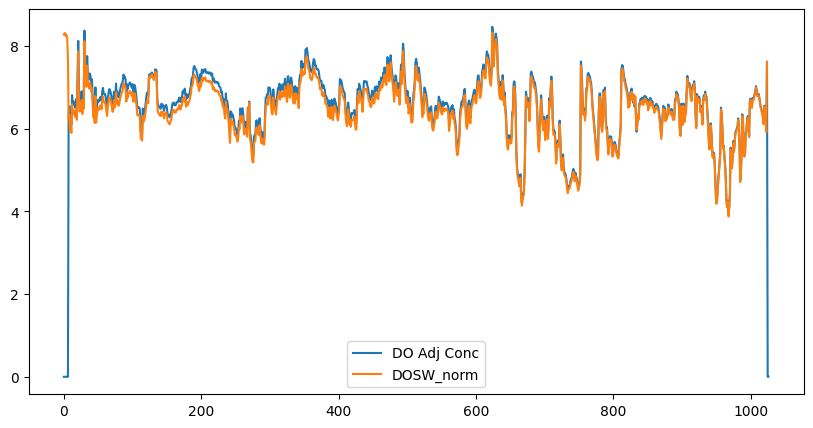

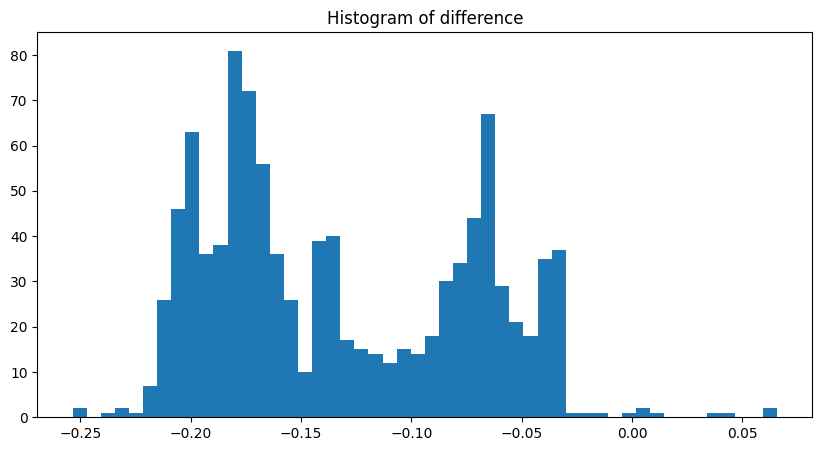

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the file
df_adj = pd.read_csv('../data/RB1_AdjDO_6_9_2023_lkg.csv')

# Replace NaN values with 0
df_adj['do_adj'].fillna(0, inplace=True)

# Normalize DOSW by dividing by 1e17 to get rid of e+17
df['DOSW_norm'] = df['DOSW'] / 1e17

# Compare the column "DO Adj Conc  (mg/L) c:1 2" with the column DOSW in the df
plt.figure(figsize=(10, 5))
plt.plot(df_adj['do_adj'], label='DO Adj Conc')
plt.plot(df['DOSW_norm'], label='DOSW_norm')

plt.legend()
plt.show()

# Plot the histogram of the difference
diff = df['DOSW_norm'][7:-7] - df_adj['do_adj'][7:-7]
plt.figure(figsize=(10, 5))
plt.hist(diff.dropna(), bins=50)
plt.title('Histogram of difference')
plt.show()


In [103]:
# Calculate error percentage
error_percentage = (diff / df['DOSW_norm'][7:-7]) * 100
print("Error Percentage: ", error_percentage.mean())



Error Percentage:  -2.0236116283478935


In [84]:
df_adj['do_adj'].shape
df['DOSW'].shape

(1027,)

In [85]:
print(df_adj['do_adj'].value_counts(dropna=False))

do_adj
0.000000    9
6.101767    1
6.732335    1
6.279455    1
6.614249    1
           ..
7.509452    1
7.508105    1
7.911115    1
7.882841    1
7.620000    1
Name: count, Length: 1019, dtype: int64


In [86]:
print(df['DOSW'].value_counts(dropna=False))

DOSW
NaN             2
6.686044e+17    1
6.437844e+17    1
6.455344e+17    1
6.545991e+17    1
               ..
7.190775e+17    1
7.193548e+17    1
7.289364e+17    1
7.233025e+17    1
7.425587e+17    1
Name: count, Length: 1026, dtype: int64
